In [1]:
import pandas as pd

In [2]:
import yfinance as yf
import datetime as dt

start = dt.datetime(2021, 7, 1)
end = dt.datetime(2022, 1, 27)
symbol = 'Zomato.NS'  # Stock symbol in uppercase

stk_data = yf.download(symbol, start=start, end=end)

[*********************100%%**********************]  1 of 1 completed


In [3]:
stk_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-07-23,116.000000,138.899994,115.000000,126.000000,126.000000,694895290
2021-07-26,126.349998,143.750000,125.300003,140.649994,140.649994,249723854
2021-07-27,141.699997,147.800003,127.750000,132.899994,132.899994,240341900
2021-07-28,131.000000,135.000000,123.550003,131.199997,131.199997,159793731
2021-07-29,134.949997,144.000000,132.199997,141.550003,141.550003,117973089
...,...,...,...,...,...,...
2022-01-19,131.699997,132.399994,128.250000,129.199997,129.199997,27812341
2022-01-20,127.949997,130.699997,125.000000,125.199997,125.199997,23290545
2022-01-21,125.150002,125.150002,112.550003,113.650002,113.650002,59805922


In [4]:
stk_data=stk_data[["Open","Low","High","Close"]]

In [5]:
column="Close"

In [6]:
from sklearn.preprocessing import MinMaxScaler
Ms=MinMaxScaler()
data1=Ms.fit_transform(stk_data[[column]])
print("Length:",data1.shape)

Length: (128, 1)


In [7]:
training_size = round(len(data1 ) * 0.80)
print(training_size)
X_train=data1[:training_size]
X_test=data1[training_size:]
print("X_train length:",X_train.shape)
print("X_test length:",X_test.shape)
y_train=data1[:training_size]
y_test=data1[training_size:]
print("y_train length:",y_train.shape)
print("y_test length:",y_test.shape)

102
X_train length: (102, 1)
X_test length: (26, 1)
y_train length: (102, 1)
y_test length: (26, 1)


In [8]:
orders=[(0,0,0),(0,0,1),(2,0,1),(1,1,1)]
best_scores={'RMSE':float('inf'),'MAPE':float('inf')}
best_orders={'RMSE':None,'MAPE':None}
#orderslist=[]
#rscorelist=[]
for i in orders:
    #orderslist.append(i)
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    model = SARIMAX(data1, order=i, seasonal_order=(0,0,0,12))
    model_fit = model.fit()
    # make prediction
    y_pred= model_fit.predict(0, len(data1)-1)
    #print(y_pred)
    from stockFunctions import rmsemape
    rmse_Test,maPe_Test=rmsemape(data1,y_pred)
    if rmse_Test<best_scores['RMSE']:
        best_scores['RMSE']=rmse_Test
        best_orders['RMSE']=i
    if maPe_Test<best_scores['MAPE']:
        best_scores['MAPE']=maPe_Test
        best_orders['MAPE']=i
print(f"\nBest order based on RMSE: {best_orders['RMSE']} with a score of {best_scores['RMSE']}")
print(f"\nBest order based on MAPE: {best_orders['MAPE']} with a score of {best_scores['MAPE']}")

RMSE_Test 0.6740720740740873
MAPE_Test 0.9921875
RMSE_Test 0.3620425486700411
MAPE_Test 1980417549792.9067


C:\Users\Admin\anaconda3\envs\timeseries\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Admin\anaconda3\envs\timeseries\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RMSE_Test 0.08539802700607922
MAPE_Test 11194759594327.309
RMSE_Test 0.08508892166496677
MAPE_Test 12261434209159.932

Best order based on RMSE: (1, 1, 1) with a score of 0.08508892166496677

Best order based on MAPE: (0, 0, 0) with a score of 0.9921875


In [9]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(data1, order=best_orders['RMSE'],seasonal_order=(0,0,0,12))
model_fit = model.fit()
# make prediction
y_pred= model_fit.predict(len(X_train), len(data1)-1)
#print(y_pred)
from stockFunctions import rmsemape
rmsemape(y_test,y_pred)          

RMSE_Test 0.08921958400744145
MAPE_Test 60363983798940.88


(0.08921958400744145, 60363983798940.88)

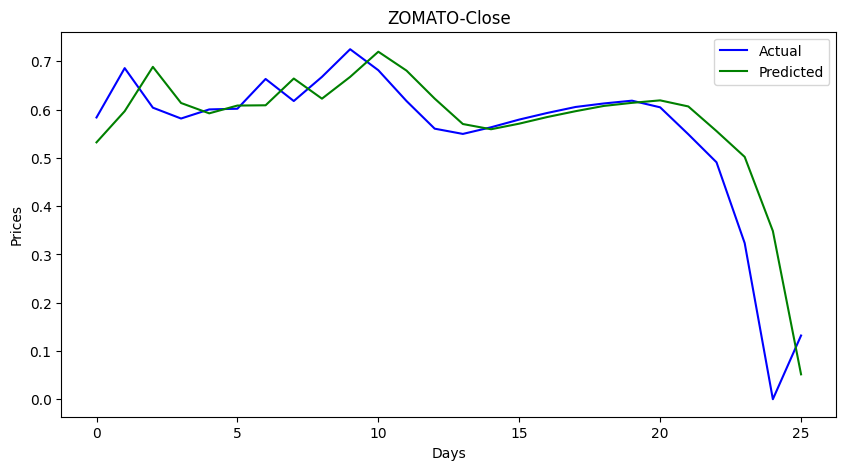

In [11]:
from stockFunctions import graph
graph(y_test,y_pred,"Actual","Predicted","ZOMATO-Close","Days","Prices")

In [15]:
from stockFunctions import conversionSingle
aTestNormTable=conversionSingle(y_test,["Close"])
actual_stock_price_test_ori=Ms.inverse_transform(aTestNormTable)
actual_stock_price_test_oriA=conversionSingle(actual_stock_price_test_ori,["Close"])

In [16]:
from stockFunctions import conversionSingle
pTestNormTable=conversionSingle(y_pred,["Close"])
predicted_stock_price_test_ori=Ms.inverse_transform(pTestNormTable)
predicted_stock_price_test_oriP=conversionSingle(predicted_stock_price_test_ori,["Close"])

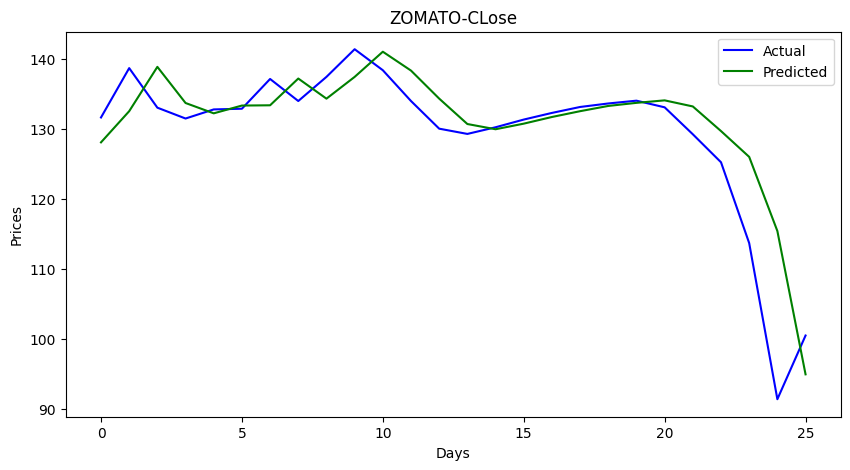

In [17]:
from stockFunctions import graph
graph(actual_stock_price_test_oriA,predicted_stock_price_test_oriP,"Actual","Predicted","ZOMATO-CLose","Days","Prices")

In [26]:
forecast=model_fit.predict(len(data1), len(data1)+7)

In [27]:
forecast

array([0.16671739, 0.19497017, 0.21794863, 0.2366374 , 0.25183729,
       0.26419962, 0.27425411, 0.2824316 ])

In [28]:
from stockFunctions import conversionSingle
fTestNormTable=conversionSingle(forecast,["Closefore"])
forecast_stock_price_test_ori=Ms.inverse_transform(fTestNormTable)
forecast_stock_price_test_oriF=conversionSingle(forecast_stock_price_test_ori,["Closefore"])

In [29]:
forecast_stock_price_test_oriF.to_csv("CloseZomato.csv",index=False)

In [30]:
forecast_stock_price_test_oriF

,Closefore
0,102.845163
1,104.793193
2,106.377558
3,107.666148
4,108.714181
5,109.566564
6,110.259821
7,110.823659


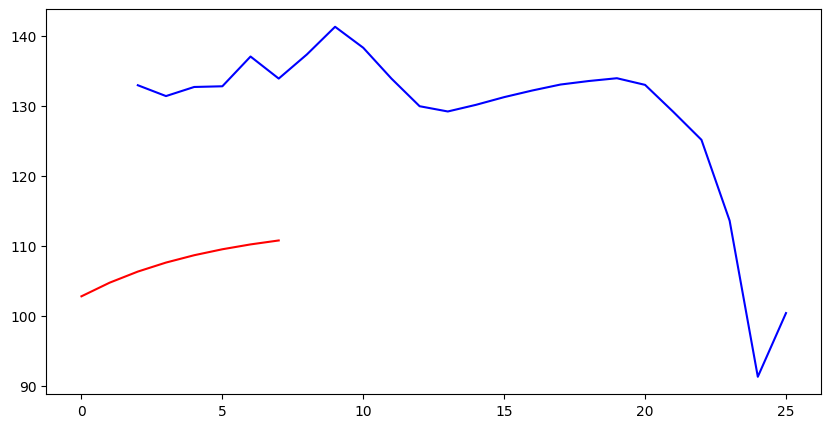

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(actual_stock_price_test_oriA[2:2225], color = 'blue', label="Actual")
plt.plot(forecast_stock_price_test_oriF, color = 'red', label ="Predicted")